In [1]:
import torch
import coba as cb
import matplotlib.pyplot as plt

In [2]:
#here are our learners used in the experiments below
class CauchyMulticlass(torch.nn.Module):
    def __init__(self, *, dobs, n_rff, sigma, n_classes, device='cpu'):
        from math import pi, sqrt
        
        super().__init__()
        assert n_rff == int(n_rff) and n_rff > 0
        assert 0 < sigma
        
        self.rffW = torch.nn.Parameter(torch.empty(dobs, n_rff).cauchy_(sigma = sigma).to(device), 
                                       requires_grad=False)
        self.rffb = torch.nn.Parameter((2 * pi * torch.rand(n_rff)).to(device),
                                       requires_grad=False)
        self.sqrtrff = torch.nn.Parameter(torch.Tensor([sqrt(n_rff)]).to(device), 
                                          requires_grad=False)
        self.linear = torch.nn.Linear(in_features=n_rff, out_features=n_classes, device=device)
        self.softmax = torch.nn.Softmax(dim=1)
               
    def logits(self, Xs):
        with torch.no_grad():
            rff = (torch.matmul(Xs, self.rffW) + self.rffb).cos() / self.sqrtrff
        return self.linear(rff)

    def probs(self, Xs):
        return self.softmax(self.logits(Xs))
    
class BilinearCauchyMulticlass(torch.nn.Module):
    def __init__(self, *, n_users, n_feedbacks, d_embed, **kwargs):
        super().__init__()

        assert n_users == int(n_users) and n_users > 0
        assert n_feedbacks == int(n_feedbacks) and n_feedbacks > 0

        self.cauchy = CauchyMulticlass(**kwargs)
        self.embedU = torch.nn.Embedding(n_users, d_embed)
        self.embedF = torch.nn.Embedding(n_feedbacks, d_embed)
        self.softmax = torch.nn.Softmax(dim=1)

    def logits(self, Xs):
        cauchylogits = self.cauchy.logits(Xs[:,2:])
        Fs = self.embedF(Xs[:,0].long())
        Us = self.embedU(Xs[:,1].long())
        UsdotFs = torch.inner(Us, Fs)
        return torch.mul(UsdotFs, cauchylogits)

    def probs(self, Xs):
        return self.softmax(self.logits(Xs))

class PythonIGL:
    def __init__(self, *, n_users, n_feedbacks, d_embed, sigma, n_rff, lr, epsilon, epsilon_t0):
        super().__init__()

        assert n_users == int(n_users) and n_users > 0 
        assert n_feedbacks == int(n_feedbacks) and n_feedbacks > 0 
        assert d_embed == int(d_embed) and d_embed > 0
        assert 0 < sigma
        assert n_rff == int(n_rff) and n_rff > 0
        assert 0 < lr

        self.regressor = None
        self.epsilon = epsilon
        self.epsilon_t0 = epsilon_t0
        self.t = epsilon_t0
        self.ikmodel = None
        self.sigma = sigma
        self.n_rff = n_rff
        self.lr = lr
        self.n_users = n_users
        self.n_feedbacks = n_feedbacks
        self.d_embed = d_embed
    
    def predict(self, context, actions):
        self.__setupRegressor(context=context, actions=actions)
        with torch.no_grad():
            logits = self.regressor.logits(torch.Tensor(context).unsqueeze(0))
            predict = torch.argmax(logits)
            myeps = self.__myeps()
            paction = [myeps/len(actions)]*len(actions)
            paction[predict] += 1 - myeps
            self.t += 1
            return paction

    def learn(self, context, actions, aindex, feedback, probability):
        actioniw = 1 / (len(actions)*probability)
        self.__setupInverseKinematics(context=context, actions=actions, feedback=feedback)
        with torch.no_grad():
            logits = self.ikmodel.logits(torch.Tensor(feedback+tuple(context)).unsqueeze(0))
            predict = torch.argmax(logits)
            ikacc = 1 if predict.item() == aindex else 0
            paction = self.ikmodel.softmax(logits)[0]
            fakereward = 1 if paction[aindex].item() * len(actions) > 2 else 0            

        self.ikopt.zero_grad()
        loss = actioniw * self.ikloss(self.ikmodel.logits(torch.Tensor(feedback+tuple(context)).unsqueeze(0)), torch.Tensor([aindex]).long())
        loss.backward()
        self.ikopt.step()

        self.regopt.zero_grad()
        regpred = self.regressor.probs(torch.Tensor(context).unsqueeze(0))
        regloss = actioniw * self.regloss(regpred[:,aindex], torch.Tensor([fakereward]))
        regloss.backward()
        self.regopt.step()

        cb.CobaContext.learning_info.update(ikloss=loss.item(), ikacc=ikacc, fakereward=fakereward, epsilon=self.__myeps(), regloss=regloss.item())

    def getUserEmbedding(self, userids):
        return self.ikmodel.embedU(userids)

    def getFeedbackEmbedding(self, feedbackids):
        return self.ikmodel.embedF(feedbackids)

    def __setupRegressor(self, *, context, actions):
        if self.regressor is None:
            self.regressor = CauchyMulticlass(dobs=len(context), sigma=self.sigma, 
                                              n_rff=self.n_rff, n_classes=len(actions))
            self.regloss = torch.nn.BCELoss()
            self.regopt = torch.optim.Adam((p for p in self.regressor.parameters() if p.requires_grad), lr=self.lr)
        
    def __myeps(self):
        return self.epsilon * (self.epsilon_t0 / self.t)**(1/3)

    def __setupInverseKinematics(self, *, context, actions, feedback):
        if self.ikmodel is None:
            self.ikmodel = BilinearCauchyMulticlass(n_users=self.n_users, n_feedbacks=self.n_feedbacks, d_embed=self.d_embed, 
                                                    dobs=len(feedback)+len(context)-2, sigma=self.sigma, 
                                                    n_rff=self.n_rff, n_classes=len(actions))
            self.ikloss = torch.nn.CrossEntropyLoss()
            self.ikopt = torch.optim.Adam((p for p in self.ikmodel.parameters() if p.requires_grad), lr=self.lr)

In [3]:
%%time 

#here we create an IGL problem from the covertype dataset one time. It 
#takes about 45 seconds to load due to the number of features and examples.
covertype_id = 150
ndata        = 500_000
n_users      = 100
n_words      = 100

environment = cb.Environments.cache_dir('./.coba_cache')                           #(1) set a cache directory
environment = environment.from_openml(data_id=covertype_id, take=ndata)            #(2) begin with covertype
environment = environment.scale(shift='min',scale='minmax')                        #(3) scale features to [0,1]
environment = environment.grounded(n_users, n_users/2, n_words, n_words/2, seed=5) #(4) turn into an igl problem
environment = environment.materialize()                                            #(5) and finally, materialize

CPU times: total: 35.5 s
Wall time: 36.9 s


In [5]:
#This block creates our learner and runs our experiment using the environment we created above.
#Coba takes care of feeding examples to our learner one at a time and tracking learning progress.
#Once the experiment is finished we get a result object that we can plot to see learner performance.  
#This takes about 20 minutes to run.
learner    = PythonIGL(n_users=n_users, n_feedbacks=n_words, d_embed=2, sigma=0.2, n_rff=512, lr=2.5e-3, epsilon=1, epsilon_t0=1000)
experiment = cb.Experiment(environment, learner)
result     = experiment.run()

2022-12-03 17:36:22 -- Processing chunk...
2022-12-03 17:36:22 --   * Recording Learner 0 parameters... (0.0 seconds) (completed)
2022-12-03 17:36:22 --   * Recording Environment 0 statistics... (0.0 seconds) (completed)
2022-12-03 17:56:13 --   * Evaluating Learner 0 on Environment 0... (1191.11 seconds) (completed)


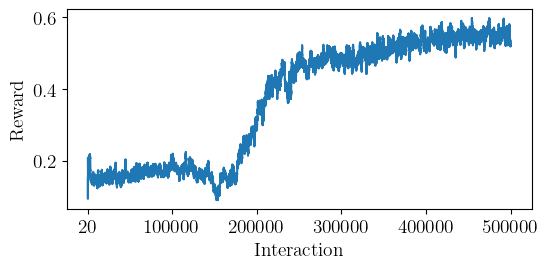

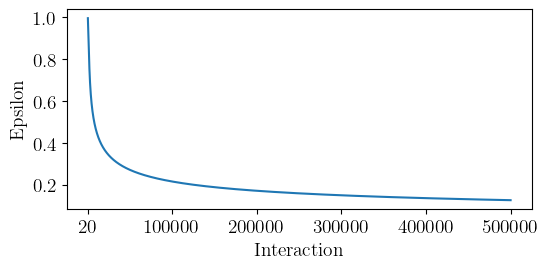

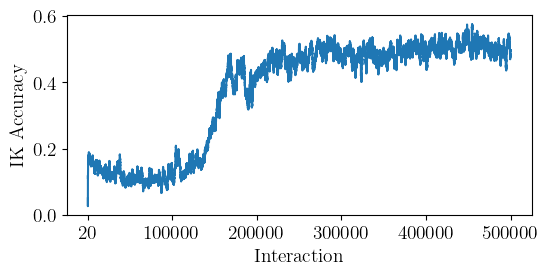

In [8]:
#Here we provide three plots showing the learning outcomes of our PythonIGL learner.
#The x-axis in each plot is the number of training interactions PythonIGL had encountered.
#We clip the first 20 training samples when plotting because the average values are unreliable.
plt.rc('font',weight='normal',size=14)
figsize = (6,4)

plt.figure(figsize=figsize)
result.plot_learners(y='reward',span=1000,xlim=(20,500_000),out=None)
plt.title('',loc='left')
plt.legend('',frameon=False)
plt.show()

plt.figure(figsize=figsize)
result.plot_learners(y='epsilon',span=1000,xlim=(20,500_000),out=None)
plt.title('',loc='left')
plt.legend('',frameon=False)
plt.show()

plt.figure(figsize=figsize)
result.plot_learners(y='ikacc',span=1000,xlim=(20,500_000),out=None)
plt.ylabel('IK Accuracy')
plt.title('',loc='left')
plt.legend('',frameon=False)
plt.show()

In [11]:
result.interactions.to_pandas().groupby(['reward', 'fakereward'])[['reward', 'fakereward']].count()

reward  fakereward
reward fakereward                    
0      0           304193      304193
       1            11678       11678
1      0            47491       47491
       1           136638      136638

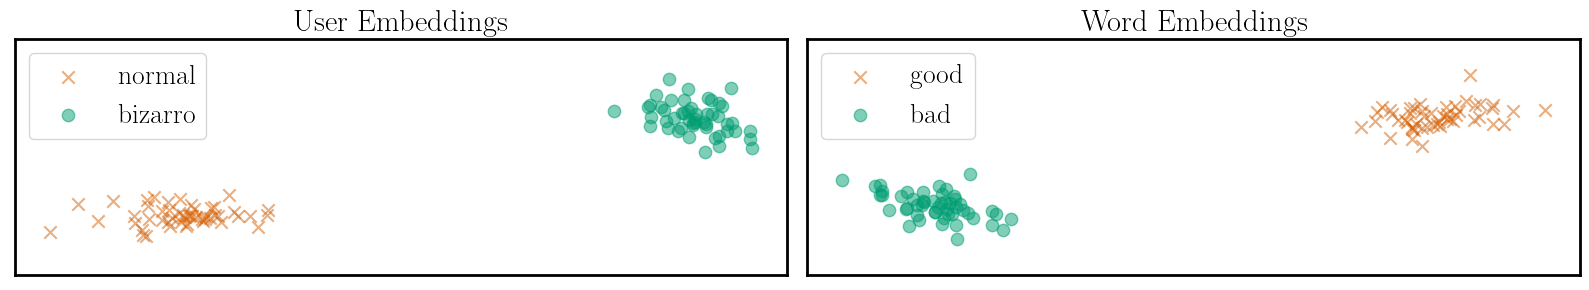

In [7]:
userids = environment[0][-2].userids
wordids = environment[0][-2].wordids

normalids = environment[0][-2].normalids
goodwords = environment[0][-2].goodwords

plt.rcParams.update({"text.usetex": True,"font.family": "Serif"})

with torch.no_grad():
    uembed = learner.getUserEmbedding(torch.Tensor(userids).long()).numpy()
    wordembed = learner.getFeedbackEmbedding(torch.Tensor(wordids).long()).numpy()

    with plt.style.context('seaborn-colorblind'):
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches(16, 3)

        dotsize = 20*(2**2)

        nx, ny = list(zip(*[ (x, y) for x, y, u in zip(uembed[:,0], uembed[:,1], userids) if u in normalids ]))
        ax[0].scatter(nx, ny, c='C2', s=dotsize, marker='x', label='normal', alpha=0.5)
        bx, by = list(zip(*[ (x, y) for x, y, u in zip(uembed[:,0], uembed[:,1], userids) if u not in normalids ]))
        ax[0].scatter(bx, by, c='C1', s=dotsize, marker='o', label='bizarro', alpha=0.5)
        ax[0].legend(scatterpoints=1)
        ax[0].set_title('User Embeddings', fontsize=22)

        gx, gy = list(zip(*[ (x, y) for x, y, u in zip(wordembed[:,0], wordembed[:,1], wordids) if u in goodwords ]))
        ax[1].scatter(gx, gy, c='C2', s=dotsize, marker='x', label='good', alpha=0.5)
        bx, by = list(zip(*[ (x, y) for x, y, u in zip(wordembed[:,0], wordembed[:,1], wordids) if u not in goodwords ]))
        ax[1].scatter(bx, by, c='C1', s=dotsize, marker='o', label='bad', alpha=0.5)
        ax[1].legend(scatterpoints=1)
        ax[1].set_title('Word Embeddings', fontsize=22)

        for a in ax:
            a.tick_params(labelsize=18)
            a.legend(fontsize=20)
            for axis in ['top','bottom','left','right']:
                a.spines[axis].set_linewidth(2)
            a.tick_params(width=2)
            a.set_xticks([])
            a.set_yticks([])
            a.set_xlim(a.get_xlim()[0],a.get_xlim()[1])
            a.set_ylim(a.get_ylim()[0]-.4,a.get_ylim()[1]+.4)

        plt.tight_layout()
        plt.xticks([])
        plt.savefig('userwordembeddings.pdf')